## Load the dataset

In [105]:
import sys

sys.path.append('..')

In [106]:
import numpy as np
import pandas as pd

df = pd.read_csv('../processed_data/tabular_data/data.csv', index_col=None)
label = df['label'].astype(int).to_numpy()
df.drop(columns=['label'], axis=1, inplace=True)
data = df.to_numpy()

In [107]:
from audio_toolbox.metrics import audio_dataset_split

RANDOM_STATE = 42
X_train, y_train, _, _, X_test, y_test = \
    audio_dataset_split(data, label, train_val_test_ratio=(0.9, 0, 0.1), random_state=RANDOM_STATE)

In [108]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit the scaler on the training set and transform all sets
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Try different models

In [109]:
RANDOM_STATE = 42
np.random.seed(42)

In [110]:
import matplotlib.pyplot as plt
from audio_toolbox.metrics import calculate_acc, precision_recall, visualize_confusion_matrices

def fit_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name='Model'):
    model.fit(X_train, y_train)
    print('Model fitting finished')

    conf_mats = []
    for x, y, split in zip([X_train, X_test],
                    [y_train, y_test],
                    ['Train', 'Test']):
        acc, correct, incorrect = calculate_acc(model, x, y)
        print(f'{split} accuracy: {acc:.4f}%, {len(incorrect)} mismatches out of {len(incorrect) + len(correct)} samples')
        conf_mat, precision, recall, f1 = precision_recall(model, x, y, return_each_class=False)
        conf_mats.append(conf_mat)
        print(f'(Averaged) {split} precision: {precision:.4f}, recall: {recall:.4f}, f1 score: {f1:.4f}')
        
    visualize_confusion_matrices(conf_mats,
                                titles=('Train', 'Test'),
                                grand_title=f'Confusion matrices for {model_name}')

Model fitting finished
Train accuracy: 85.4283%, 131 mismatches out of 899 samples
(Averaged) Train precision: 0.8533, recall: 0.8540, f1 score: 0.8532
Test accuracy: 70.0000%, 30 mismatches out of 100 samples
(Averaged) Test precision: 0.7074, recall: 0.6921, f1 score: 0.6927


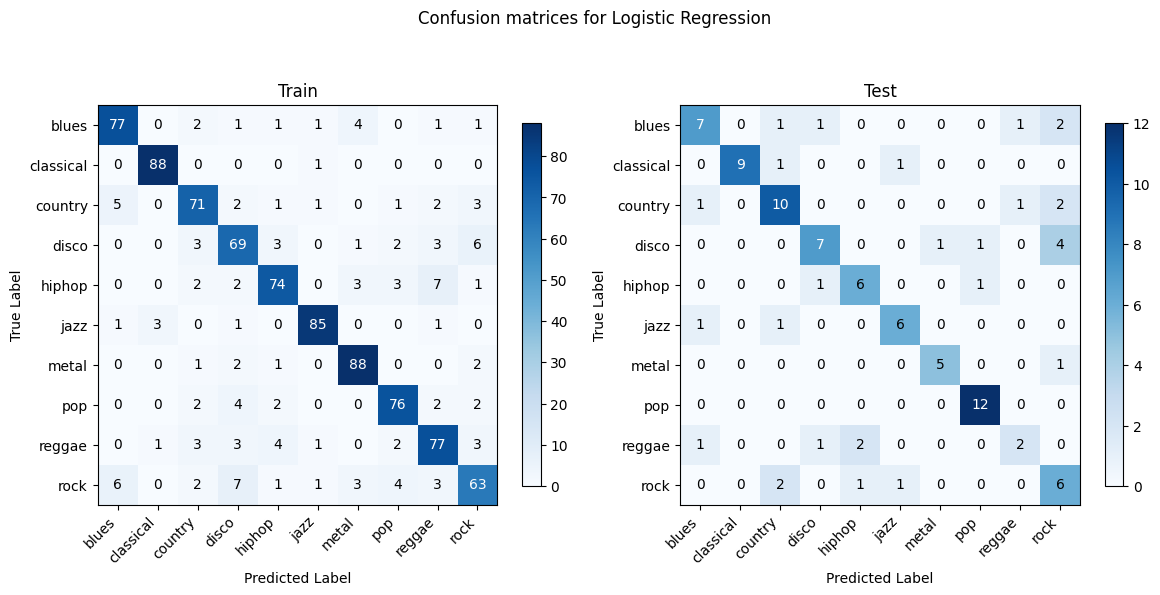

In [111]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(max_iter=1000, C=1e-1, random_state=RANDOM_STATE)
fit_and_evaluate_model(logistic_model, X_train, y_train, X_test, y_test, 'Logistic Regression')

Model fitting finished
Train accuracy: 92.6585%, 66 mismatches out of 899 samples
(Averaged) Train precision: 0.9275, recall: 0.9267, f1 score: 0.9267
Test accuracy: 78.0000%, 22 mismatches out of 100 samples
(Averaged) Test precision: 0.7897, recall: 0.7581, f1 score: 0.7650


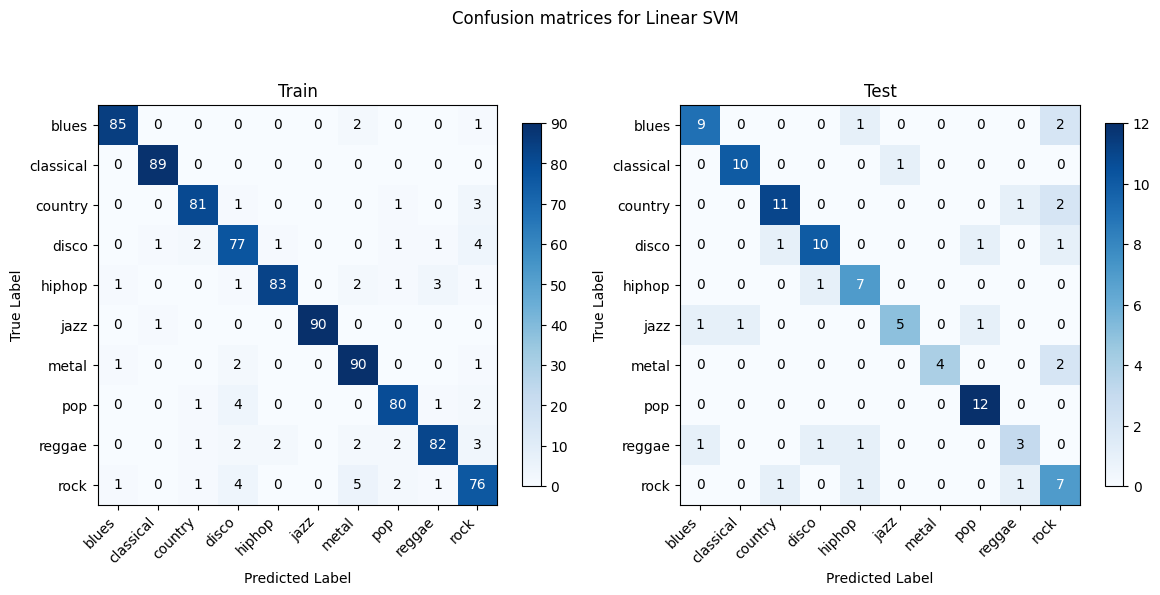

In [112]:
from sklearn.svm import SVC

svm_classifier = SVC(kernel='rbf', C=1, random_state=RANDOM_STATE)
fit_and_evaluate_model(svm_classifier, X_train, y_train, X_test, y_test, 'Linear SVM')

Model fitting finished
Train accuracy: 96.3293%, 33 mismatches out of 899 samples
(Averaged) Train precision: 0.9637, recall: 0.9633, f1 score: 0.9633
Test accuracy: 76.0000%, 24 mismatches out of 100 samples
(Averaged) Test precision: 0.7778, recall: 0.7421, f1 score: 0.7490


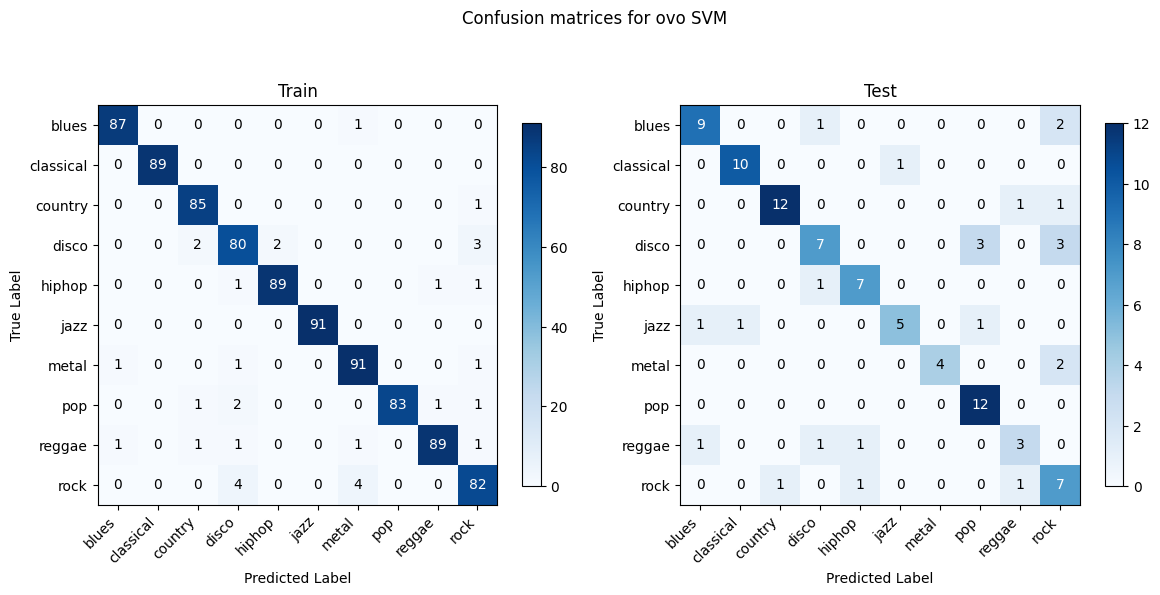

In [113]:
from sklearn.svm import SVC

ovo_svm = SVC(kernel='rbf', decision_function_shape='ovo', C=2, random_state=RANDOM_STATE)
fit_and_evaluate_model(ovo_svm, X_train, y_train, X_test, y_test, 'ovo SVM')

Model fitting finished
Train accuracy: 99.8888%, 1 mismatches out of 899 samples
(Averaged) Train precision: 0.9989, recall: 0.9989, f1 score: 0.9989
Test accuracy: 80.0000%, 20 mismatches out of 100 samples
(Averaged) Test precision: 0.7862, recall: 0.8049, f1 score: 0.7892


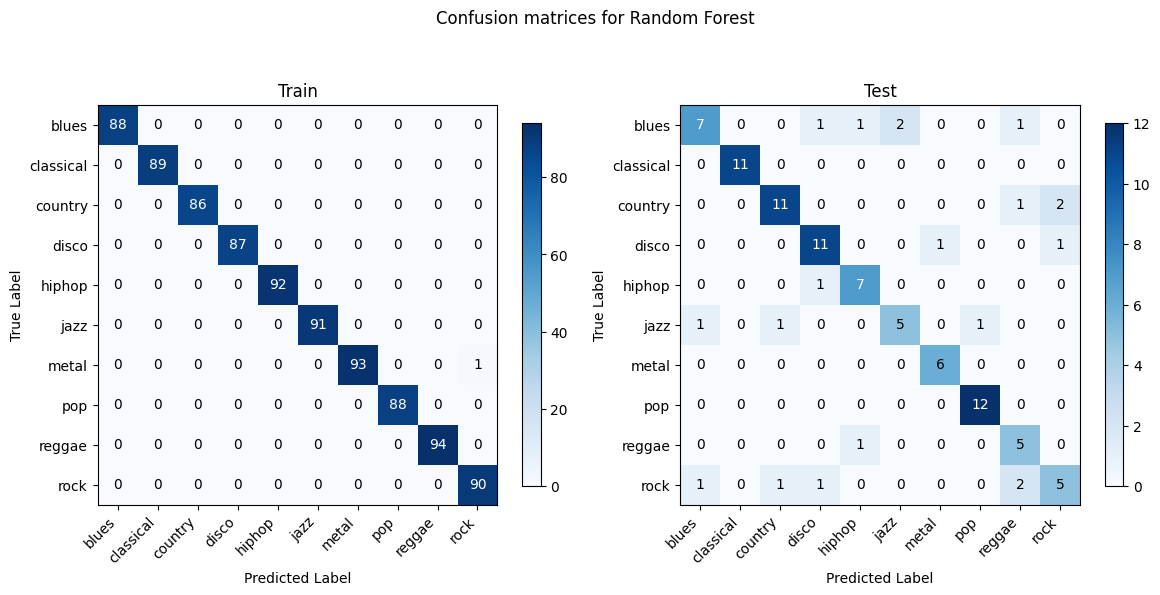

In [114]:
from sklearn.ensemble import RandomForestClassifier

rand_forest_classifier = RandomForestClassifier(max_depth=10,
                                                max_features=10,
                                                random_state=RANDOM_STATE)
fit_and_evaluate_model(rand_forest_classifier, X_train, y_train, X_test, y_test, 'Random Forest')

Model fitting finished
Train accuracy: 61.2903%, 348 mismatches out of 899 samples
(Averaged) Train precision: 0.6259, recall: 0.6122, f1 score: 0.6092
Test accuracy: 66.0000%, 34 mismatches out of 100 samples
(Averaged) Test precision: 0.6733, recall: 0.6609, f1 score: 0.6577


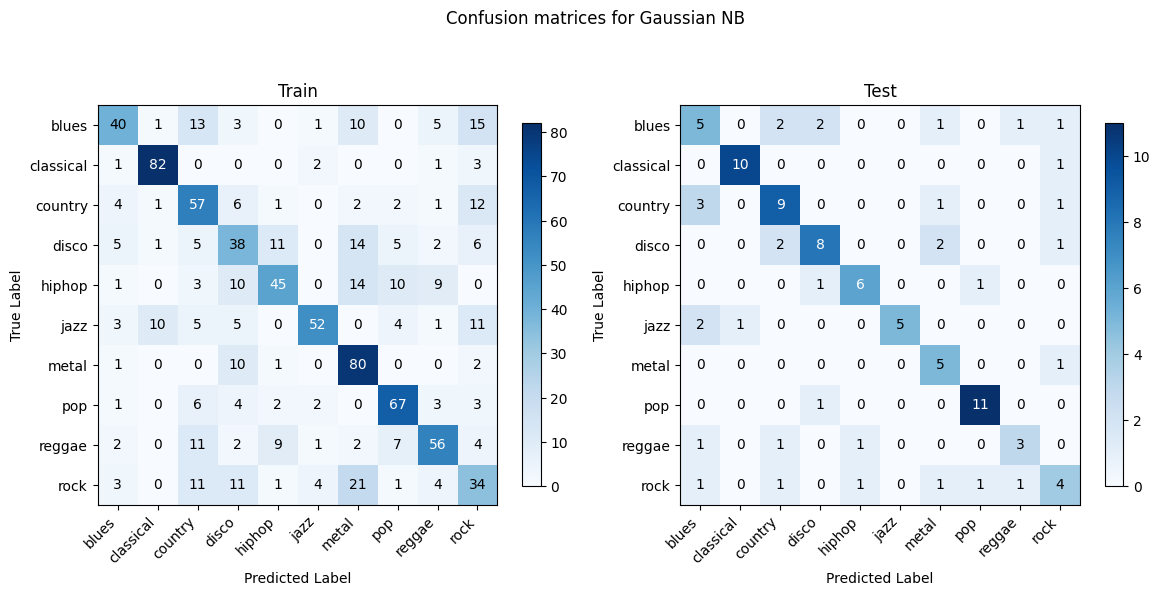

In [115]:
from sklearn.naive_bayes import GaussianNB

gnb_classifier = GaussianNB()
fit_and_evaluate_model(gnb_classifier, X_train, y_train, X_test, y_test, 'Gaussian NB')

Model fitting finished
Train accuracy: 99.8888%, 1 mismatches out of 899 samples
(Averaged) Train precision: 0.9989, recall: 0.9989, f1 score: 0.9989
Test accuracy: 84.0000%, 16 mismatches out of 100 samples
(Averaged) Test precision: 0.8392, recall: 0.8324, f1 score: 0.8320


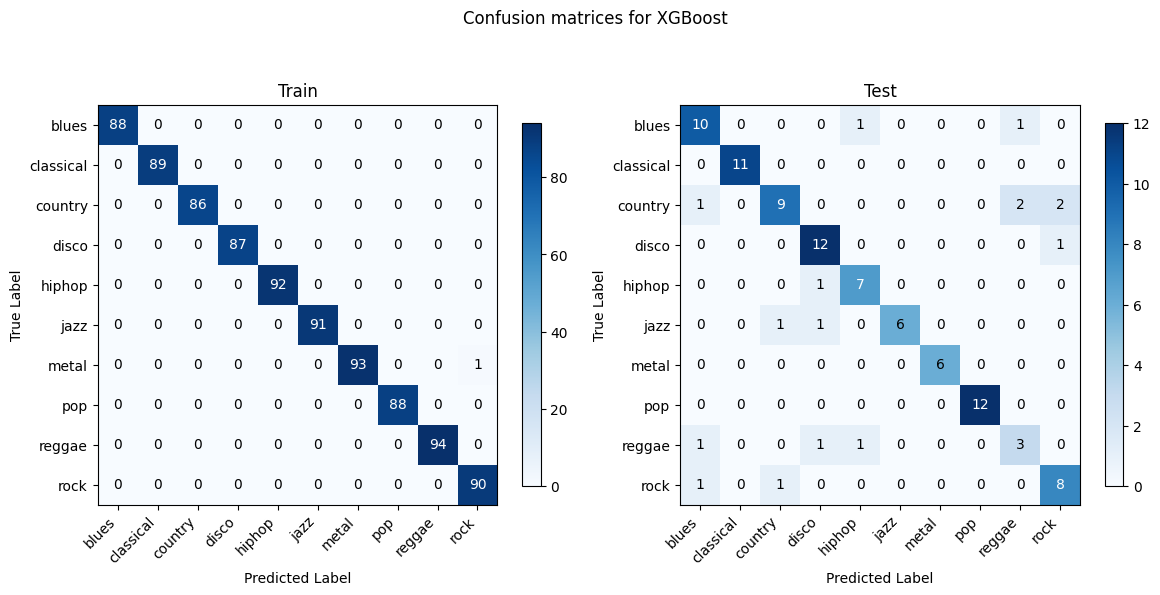

In [116]:
from sklearn.ensemble import GradientBoostingClassifier

xgboost_classifier = GradientBoostingClassifier(max_depth=10, max_features=10, random_state=RANDOM_STATE)
fit_and_evaluate_model(xgboost_classifier, X_train, y_train, X_test, y_test, 'XGBoost')

In [117]:
current_models = [logistic_model, svm_classifier, ovo_svm, rand_forest_classifier, gnb_classifier, xgboost_classifier]
current_model_names = ["Logistic", "SVM", "OVO SVM", "Random Forest", "Gaussian NB", "XGBoost"]

In [118]:
from audio_toolbox.metrics import kfold_validation
import warnings

N_SPLITS = 10

accs = {}
f1s = {}

scaled_data = scaler.transform(data)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model, name in zip(current_models, current_model_names):
        print(f"Benchmarking {name}")
        avg_acc, avg_precision, avg_recall, avg_f1 = kfold_validation(model, scaled_data, label, n_splits=N_SPLITS)
        accs[name] = avg_acc
        f1s[name] = avg_f1
        print(f"Average Accuracy: {avg_acc:.4f}")
        print(f"Average Precision: {avg_precision:.4f}")
        print(f"Average Recall: {avg_recall:.4f}")
        print(f"Average F1 Score: {avg_f1:.4f}")
        print()


Benchmarking Logistic
Average Accuracy: 71.3667
Average Precision: 0.7214
Average Recall: 0.7139
Average F1 Score: 0.7101

Benchmarking SVM
Average Accuracy: 72.9646
Average Precision: 0.7376
Average Recall: 0.7299
Average F1 Score: 0.7242

Benchmarking OVO SVM
Average Accuracy: 73.9657
Average Precision: 0.7518
Average Recall: 0.7399
Average F1 Score: 0.7352

Benchmarking Random Forest
Average Accuracy: 68.0667
Average Precision: 0.6834
Average Recall: 0.6809
Average F1 Score: 0.6746

Benchmarking Gaussian NB
Average Accuracy: 57.1606
Average Precision: 0.5984
Average Recall: 0.5717
Average F1 Score: 0.5616

Benchmarking XGBoost
Average Accuracy: 71.5677
Average Precision: 0.7245
Average Recall: 0.7159
Average F1 Score: 0.7114



In [119]:
import matplotlib.pyplot as plt
import numpy as np
def create_bar_chart(data, title, ylabel):
    models = list(data.keys())
    scores = list(data.values())
    fig, ax = plt.subplots(figsize=(6, 4))
    bar_positions = np.arange(len(models))
    ax.bar(bar_positions, scores, color='skyblue')
    for i, v in enumerate(scores):
        ax.text(i, v + 0.01, "{:.2f}".format(v), ha='center', va='bottom')

    ax.set_xticks(bar_positions)
    ax.set_xticklabels(models, rotation=45)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

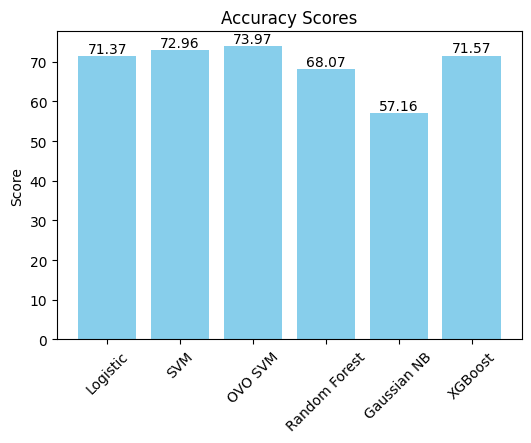

In [120]:
create_bar_chart(accs, "Accuracy Scores", "Score")
plt.show();

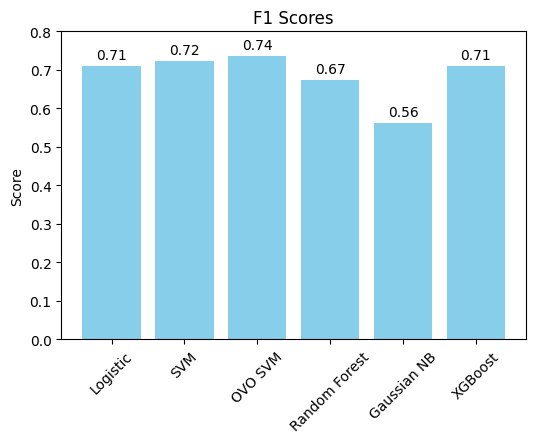

In [121]:
create_bar_chart(f1s, "F1 Scores", "Score")
plt.ylim(top=0.8)
plt.show();

## Try MLP

In [122]:
from audio_toolbox.metrics import audio_dataset_split

RANDOM_STATE = 123456
X_train, y_train, X_val, y_val, X_test, y_test = \
    audio_dataset_split(data, label, train_val_test_ratio=(0.8, 0.1, 0.1), random_state=RANDOM_STATE)

In [123]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit the scaler on the training set and transform all sets
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [124]:
import torch

device = 'cuda:2' if torch.cuda.is_available() else 'cpu' 
train_data = torch.tensor(X_train, dtype=torch.float, device=device)
val_data = torch.tensor(X_val, dtype=torch.float, device=device)
test_data = torch.tensor(X_test, dtype=torch.float, device=device)

In [125]:
# from sklearn.preprocessing import LabelBinarizer

# lb = LabelBinarizer()
# y_train = torch.tensor(lb.fit_transform(y_train), device=device)
# y_val = torch.tensor(lb.fit_transform(y_val), device=device)
# y_test = torch.tensor(lb.fit_transform(y_test), device=device)

In [126]:
y_train = torch.tensor(y_train, device=device)
y_val = torch.tensor(y_val, device=device)
y_test = torch.tensor(y_test, device=device)

In [127]:
from torch.utils.data import TensorDataset

datasets = {
    'train': TensorDataset(train_data, y_train),
    'val': TensorDataset(val_data, y_val),
    'test': TensorDataset(test_data, y_test)
}

In [128]:
from audio_toolbox.models import LinearModel

input_size = train_data.size(1)
output_size = 10
batch_size = 32

model = LinearModel(input_size, output_size, hidden_dim=128, dropout_prob=0.1, device=device)

In [129]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch import nn
# from audio_toolbox.models import OneHotCrossEntropyLoss

loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-2  # Adjust the learning rate as needed
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [130]:
from audio_toolbox.trainer import ModelTrainer

trainer = ModelTrainer(datasets, model, loss_fn, optimizer, scheduler)

In [131]:
trainer_config = {
    'save': False,
    'num_epochs': 100,
    'batch_size': batch_size,
    'log_metrics': True,
    'metric': 'acc'
}

best_state_dict = trainer.train(**trainer_config)

INFO:root:Epoch 0001, Learning rate: 0.010000, Training metric: 0.50815, Val metric: 0.52604, Test metric: 0.48594, Epoch time: 0.07096
INFO:root:Epoch 0002, Learning rate: 0.010000, Training metric: 0.67944, Val metric: 0.62760, Test metric: 0.39062, Epoch time: 0.06106


INFO:root:Epoch 0003, Learning rate: 0.010000, Training metric: 0.73968, Val metric: 0.61198, Test metric: 0.57188, Epoch time: 0.06748
INFO:root:Epoch 0004, Learning rate: 0.010000, Training metric: 0.76210, Val metric: 0.61198, Test metric: 0.56406, Epoch time: 0.06255
INFO:root:Epoch 0005, Learning rate: 0.010000, Training metric: 0.85355, Val metric: 0.48438, Test metric: 0.65781, Epoch time: 0.06569
INFO:root:Epoch 0006, Learning rate: 0.005000, Training metric: 0.88480, Val metric: 0.64323, Test metric: 0.65000, Epoch time: 0.06413
INFO:root:Epoch 0007, Learning rate: 0.005000, Training metric: 0.93363, Val metric: 0.65104, Test metric: 0.55781, Epoch time: 0.06185
INFO:root:Epoch 0008, Learning rate: 0.005000, Training metric: 0.93371, Val metric: 0.65104, Test metric: 0.62656, Epoch time: 0.06863
INFO:root:Epoch 0009, Learning rate: 0.005000, Training metric: 0.92371, Val metric: 0.64323, Test metric: 0.74219, Epoch time: 0.06138
INFO:root:Epoch 0010, Learning rate: 0.005000, T

In [132]:
trainer.load_model(best_state_dict)
train_res = trainer.predict(train_data)
val_res = trainer.predict(val_data)
test_res = trainer.predict(test_data)

In [133]:
from sklearn.metrics import accuracy_score

print(f"Train accuracy: {100 * accuracy_score(train_res.cpu(), y_train.cpu()):.2f}%")
print(f"Validation accuracy: {100 * accuracy_score(val_res.cpu(), y_val.cpu()):.2f}%")
print(f"Test accuracy: {100 * accuracy_score(test_res.cpu(), y_test.cpu()):.2f}%")

Train accuracy: 99.75%
Validation accuracy: 69.70%
Test accuracy: 71.29%
